# Photometery of R Mon BAT data

Daniel Köhn

Schwentinental, 04.12.2021

**Import libraries**

In [1]:
import imageio
import numpy as np
from numba import jit # import JIT from Numba
from matplotlib import pyplot as plt
import matplotlib.dates
from datetime import datetime, timedelta
%matplotlib inline

**Import and plot image**

In [2]:
im = imageio.imread('images/2021-10-29_L_MrCrazyPhysicist_NGC2261_r.jpg')

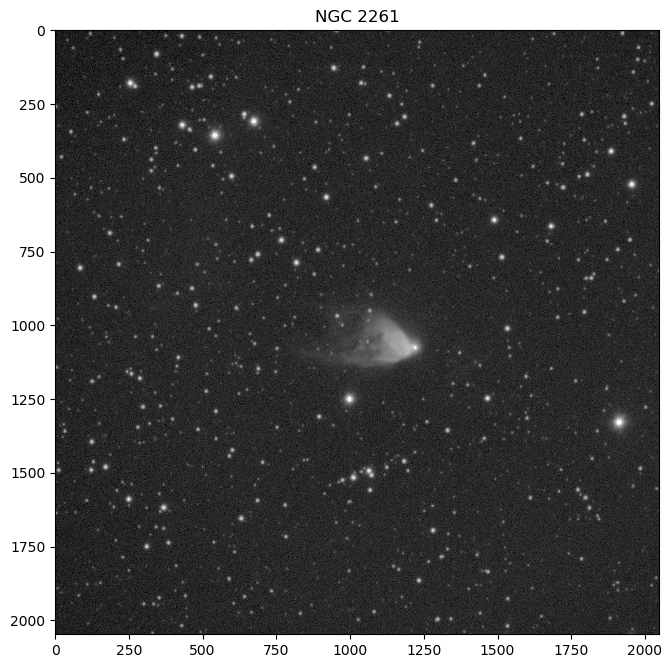

In [3]:
fig = plt.figure(figsize=(8,8), dpi=100)
cmap = 'gray'

plt.imshow(im, interpolation='none', cmap=cmap)
plt.title('NGC 2261')

plt.show()

**Define center and radius of R Mon and reference star mask**

In [4]:
# R Mon
radius_R = 8

cent_R = [1221,1077]

# reference star #1
radius_ref1 = radius_R
cent_ref1 = [818,788]
mag_ref1 = 12.8

# reference star #2
radius_ref2 = radius_R
cent_ref2 = [1515,769]
mag_ref2 = 13.5

**Function for star mask creation**

In [5]:
@jit(nopython=True) # use Just-In-Time (JIT) Compilation
def create_star_mask(im, cent, radius):
    
    nx, ny = im.shape
    
    mask = np.zeros((ny, nx))
    
    # define star mask
    for j in range (0,ny):
        for i in range (0,nx):
            
            if(radius >= np.sqrt((j-cent[1])**2+(i-cent[0])**2)):               
               mask[j,i] = 1
    
    return mask

**Define star mask for R Mon & ref stars**

In [6]:
mask_R = create_star_mask(im,cent_R,radius_R)
mask_ref1 = create_star_mask(im,cent_ref1,radius_ref1)
mask_ref2 = create_star_mask(im,cent_ref2,radius_ref2)

**Batch processing of BAT data**

In [7]:
# Get filenames from BAT_files_list.txt
files = np.genfromtxt('BAT_files_list.txt',dtype='str')

# number of images
nimg = len(files)

R_mag = np.zeros(nimg)
date = np.zeros(nimg)

# loop over files
for i in range(0,nimg):

    # save date
    date[i] = matplotlib.dates.date2num(datetime(int(files[i][0:4]), int(files[i][5:7]), int(files[i][8:10])))
    
    # import image i from file list
    im = imageio.imread('images/' + files[i] + '.jpg')

    # Compute average brightness values in each star mask
    f_R = np.mean(mask_R*im)
    f_ref1 = np.mean(mask_ref1*im)
    f_ref2 = np.mean(mask_ref2*im)

    # Compute apparent magnitude of R Mon
    dmag = (mag_ref2 - mag_ref1) / (f_ref1 - f_ref2)

    # compute difference between reference star and R Mon
    dref = f_R - f_ref2

    # compute apparent magnitude of R Mon
    R_mag[i] = mag_ref2 - dref * dmag

**Add AAVSO data**

In [8]:
date_BDVA = [matplotlib.dates.date2num(datetime(2021,10,8)),matplotlib.dates.date2num(datetime(2021,10,29))]
mag_BDVA = [11.89, 11.76]

**Plot AAVSO and B.A.T. data**

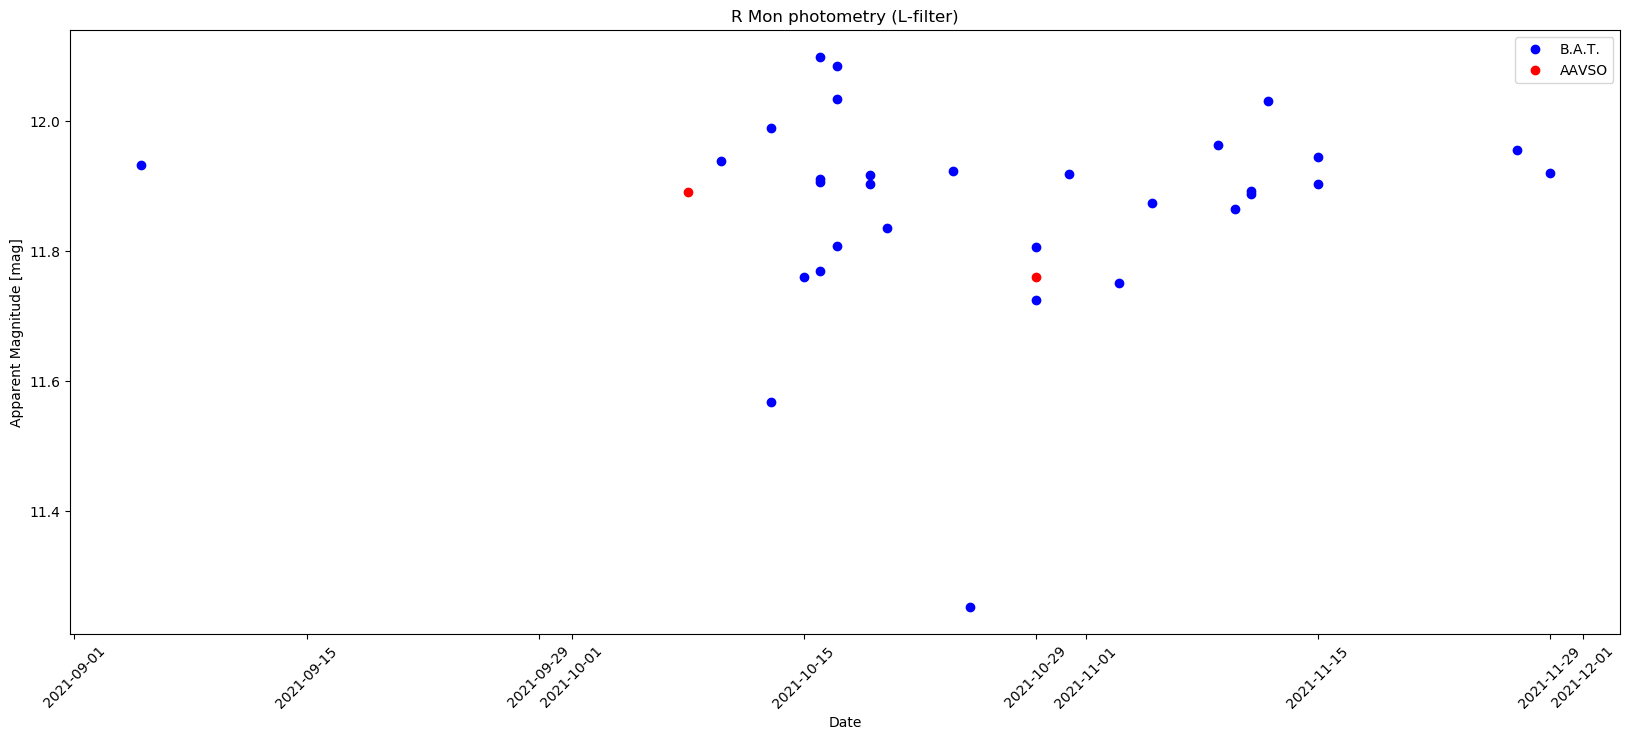

In [9]:
fig = plt.figure(figsize=(20,8), dpi=100)

plt.plot_date(date, R_mag,'bo',label='B.A.T.')
plt.plot_date(date_BDVA, mag_BDVA,'ro',label='AAVSO')
plt.title('R Mon photometry (L-filter)')
plt.xlabel('Date')
plt.ylabel('Apparent Magnitude [mag]')
plt.xticks(rotation=45)
plt.legend()
plt.savefig('BAT_R-Mon_photometry.png', format='png', dpi=100)
plt.show()